tgb - 5/21/2019 - The general goal of this notebook is to develop the new Jacobian diagnostics to assess the stability of the constrained/not-constrained networks. The sub-goals are:  
1) Developing a Jacobian diagnostics toolbox to normalize the full Jacobian to the right units and analyze the eigenvalues of the dynamical Jacobian  
2) Calculate the Jacobian as a function of latitude in our aquaplanet simulation  
3) Prepare the Jacobian for the collaboration with Noah Brenowitz  

# 1) Jacobian toolbox

## 1.1) Load CBRAIN utilities and a model

In [1]:
import tensorflow as tf
#tf.enable_eager_execution()

from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.model_diagnostics import *
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [4]:
NN = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/JNNC.h5'
NN = load_model(path,custom_objects=dict_lay)
md = ModelDiagnostics(NN,config_fn,data_fn)
NN.summary()

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]                
______________________________________________________________________

## 1.2) Calculate Jacobian for specific soundings

tgb - 5/21/2019 - I have no idea why but the tape must be set to persistent=True and the jacobian to experimental_use_pfor=False to be able to calculate the Jacobian in eager execution mode #magic

In [5]:
# itime = 1
# X, truth = md.valid_gen[itime]
# inp = tf.convert_to_tensor(np.expand_dims(X[0,:],axis=0))

# with tf.GradientTape(persistent=True) as tape:
#     tape.watch(inp)
#     pred = NN(inp)
# J = tape.jacobian(pred,inp,experimental_use_pfor=False).numpy()

tgb - 5/21/2019 - Renormalize the Jacobian to 1/(Input units) which does not mean much

In [6]:
# JAC = J.squeeze()/md.valid_gen.input_transform.div

# 1.3) Create corresponding functions

tgb - 5/21/2019 - Following https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/004_Calculating_Jacobians_of_NN_and_dynamics_of_TQ.ipynb but changed the gradient loop to a single Jacobian calculation and made use of the model diagnostics object

In [7]:
def get_TQjacobian(model,inp,sample_index,md):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;

    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs))
    with tf.GradientTape(persistent=True) as tape:
        TFinp = tf.convert_to_tensor(np.expand_dims(inp[0,:],axis=0))
        tape.watch(TFinp)
        pred = NN(TFinp)
    J = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
    .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    JTQ = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JTQ[i,j] = J[i,j] # d(dq/dt)/dq
            elif (i>29) and (j<30): JTQ[i,j] = J[90+(i-30),j]-\
                J[120+(i-30),j]-J[150+(i-30),j] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JTQ[i,j] = J[i,90+(j-30)] # d(dq/dt)/dT
            elif (i>29) and (j>29): JTQ[i,j] = J[90+(i-30),90+(j-30)]-\
                J[120+(i-30),90+(j-30)]-J[150+(i-30),90+(j-30)] # d(dTcon/dt)/dT

    return JTQ

In [8]:
def get_RADjacobian(model,inp,sample_index,md):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;
        
    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs))
    with tf.GradientTape(persistent=True) as tape:
        TFinp = tf.convert_to_tensor(np.expand_dims(inp[0,:],axis=0))
        tape.watch(TFinp)
        pred = NN(TFinp)
    J = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
    .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    JRAD = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JRAD[i,j] = J[120+i,j]
            elif (i>29) and (j<30): JRAD[i,j] = J[150+(i-30),j]
            elif (i<30) and (j>29): JRAD[i,j] = J[120+i,90+(j-30)]
            elif (i>29) and (j>29): JRAD[i,j] = J[150+(i-30),90+(j-30)]

    return JRAD

tgb - 5/21/2019 - Get radiative AND convective Jacobian for an entire batch

In [5]:
def get_RADCONjacobian(model,inp,md,ind):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# ind is the indices over which the Jacobian is calculated
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;
    
    JCON = np.zeros((60,60,len(ind)))
    JRAD = np.zeros((60,60,len(ind)))
    
    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs,len(ind)))
    for count,i in enumerate(ind):
        print('i=',i,'/',len(ind)-1,end="\r")
        with tf.GradientTape(persistent=True) as tape:
            TFinp = tf.convert_to_tensor(np.expand_dims(inp[i,:],axis=0))
            tape.watch(TFinp)
            pred = NN(TFinp)
        J[:,:,i] = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
        .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    for i in range (60):
        for j in range(60):
            # Convection
            if (i<30) and (j<30): JCON[i,j] = J[i,j,:] # d(dq/dt)/dq
            elif (i>29) and (j<30): JCON[i,j] = J[90+(i-30),j,:]-\
                J[120+(i-30),j,:]-J[150+(i-30),j,:] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JCON[i,j] = J[i,90+(j-30),:] # d(dq/dt)/dT
            elif (i>29) and (j>29): JCON[i,j] = J[90+(i-30),90+(j-30),:]-\
                J[120+(i-30),90+(j-30),:]-J[150+(i-30),90+(j-30),:] # d(dTcon/dt)/dT
            # Radiation    
            if (i<30) and (j<30): JRAD[i,j,:] = J[120+i,j,:]
            elif (i>29) and (j<30): JRAD[i,j,:] = J[150+(i-30),j,:]
            elif (i<30) and (j>29): JRAD[i,j,:] = J[120+i,90+(j-30),:]
            elif (i>29) and (j>29): JRAD[i,j,:] = J[150+(i-30),90+(j-30),:]

    return JCON,JRAD

In [6]:
from tensorflow.python.ops.parallel_for.gradients import batch_jacobian
def get_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)[None]})
    return J.squeeze()
def get_batch_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = batch_jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)})
    return J.squeeze()

tgb - 6/4/2019 - Corrected it to the right units

In [7]:
def get_RADCONjacobian(model,md,itime):
    # model is the neural network model from inp to out
    # inp is the input x generator from the generator (object = gen_obj)
    # sample_index is the reference number of the sample for x
    # md is the model diagnostics object
    # ind is the indices over which the Jacobian is calculated
    # x.shape = (#sample,#inputs) so we are evaluating the gradient of
    # y(sample_index,:) with respect to x(sample_index,:)
    # cf is the conversion factor calculated using CAM constants
    X, truth = md.valid_gen[itime]

    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;

    cf_oup = np.zeros((1,md.valid_gen.n_outputs))
    for index in range (md.valid_gen.n_outputs):
        if index<90: cf_oup[0,index]=L_V;
        elif index<210: cf_oup[0,index]=C_P;
        else: cf_oup[0,index]=1;

    JCON = np.zeros((60,60,8192))
    JRAD = np.zeros((60,60,8192))

    # J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs,len(ind)))
    # for count,i in enumerate(ind):
    #     print('i=',i,'/',len(ind)-1,end="\r")
    #     with tf.GradientTape(persistent=True) as tape:
    #         TFinp = tf.convert_to_tensor(np.expand_dims(inp[i,:],axis=0))
    #         tape.watch(TFinp)
    #         pred = NN(TFinp)
    #     J[:,:,i] = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
    #     .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    for ind in range(32):
        print('ind=',ind,'/',32,end="\r")
        sample = np.arange(256*ind,256*(ind+1))
        Jtmp = get_batch_jacobian(X[sample,:], model)*\
            np.transpose(cf_oup/md.valid_gen.output_transform.scale)\
            /(cf*md.valid_gen.input_transform.div)
        if ind==0: J = Jtmp
        else: J = np.concatenate((J,Jtmp),axis=0)
    print(J.shape)

    for i in range (60):
        for j in range(60):
            # Convection
            if (i<30) and (j<30): JCON[i,j] = J[:,i,j] # d(dq/dt)/dq
            elif (i>29) and (j<30): JCON[i,j] = J[:,90+(i-30),j]-\
                J[:,120+(i-30),j]-J[:,150+(i-30),j] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JCON[i,j] = J[:,i,90+(j-30)] # d(dq/dt)/dT
            elif (i>29) and (j>29): JCON[i,j] = J[:,90+(i-30),90+(j-30)]-\
                J[:,120+(i-30),90+(j-30)]-J[:,150+(i-30),90+(j-30)] # d(dTcon/dt)/dT
            # Radiation    
            if (i<30) and (j<30): JRAD[i,j,:] = J[:,120+i,j]
            elif (i>29) and (j<30): JRAD[i,j,:] = J[:,150+(i-30),j]
            elif (i<30) and (j>29): JRAD[i,j,:] = J[:,120+i,90+(j-30)]
            elif (i>29) and (j>29): JRAD[i,j,:] = J[:,150+(i-30),90+(j-30)]
                
    return JCON,JRAD

In [26]:
X.shape

(8192, 304)

In [11]:
JRAD2 = np.reshape(JRAD, (60,60,64,128))

In [12]:
JRAD2.shape

(60, 60, 64, 128)

In [13]:
JRAD3 = JRAD2.mean(axis=3)

In [14]:
JRAD3.shape

(60, 60, 64)

In [ ]:
np.mean(np.reshape(JRAD,(60,60,64,128)),axis=3)

In [ ]:
import h5py

JCONa = np.zeros((md.nlat,60,60))
JRADa = np.copy(JCONa)

for itime in range(100):
    print('itime=',itime)
    X, truth = md.valid_gen[itime]
    Xgeo = X.values.reshape(md.nlat, md.nlon, 304)
    for ilat in range(md.nlat):
        print('ilat=',ilat,'/',str(md.nlat-1),end="\r")
        Xlat = Xgeo[ilat,:,:]
        JCON,JRAD = get_RADCONjacobian(NN,Xlat,md,np.arange(0,md.nlon))
        JCONa[ilat,:,:] = JCON.mean(axis=2)/(itime+1)+\
        itime/(itime+1)*JCONa[ilat,:,:]
        JRADa[ilat,:,:] = JRAD.mean(axis=2)/(itime+1)+\
        itime/(itime+1)*JRADa[ilat,:,:]

    print('itime=',itime,'Saving the arrays in HDF5 format')
    with h5py.File('HDF5_DATA/014_JCONa.h5', 'w') as hf:
        hf.create_dataset("name-of-dataset",  data=JCONa)
    with h5py.File('HDF5_DATA/014_JRADa.h5', 'w') as hf:
        hf.create_dataset("name-of-dataset",  data=JRADa)

itime= 0


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


itime= 0 Saving the arrays in HDF5 format
itime= 1
itime= 1 Saving the arrays in HDF5 format
itime= 2


tgb - 5/21/2019 - Save in HDF5 format using https://stackoverflow.com/questions/20928136/input-and-output-numpy-arrays-to-h5py

In [101]:
# import h5py
# with h5py.File('HDF5_DATA/014_JCON.h5', 'w') as hf:
#     hf.create_dataset("name-of-dataset",  data=JCON)
# with h5py.File('HDF5_DATA/014_JRAD.h5', 'w') as hf:
#     hf.create_dataset("name-of-dataset",  data=JRAD)

In [20]:
# JRAD = np.swapaxes(JRAD,1,2)
# JRAD.shape
# JRAD = np.swapaxes(JRAD,0,1)
# JRAD.shape

(8192, 60, 60)

In [7]:
# with h5py.File('HDF5_DATA/014_JCONa.h5', 'r') as hf:
#     JCON = hf['name-of-dataset'][:]
# with h5py.File('HDF5_DATA/014_JRADa.h5', 'r') as hf:
#     JRAD = hf['name-of-dataset'][:]

tgb - 5/22/2019 - First calculate parameters useful for the particular graph, then graph for each latitude

In [8]:
minlev = 200; # Minimum level [hPa]
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
minind = np.argmin(abs(P-minlev*1e2));
IND = np.concatenate((np.arange(minind,30),np.arange(30+minind,60)),axis=0)

In [58]:
coor.lat[ilat]
coor.TS[ilat]

<xarray.DataArray 'TS' (lat: 64, lon: 128)>
array([[275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16],
       [275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16],
       [275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16],
       ...,
       [275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16],
       [275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16],
       [275.16, 275.16, 275.16, ..., 275.16, 275.16, 275.16]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    time     float64 0.04167
Attributes:
    units:        K
    long_name:    Surface temperature (radiative)
    cell_method:  time: mean

Text(0, 0.5, '$\\mathrm{SST\\ \\left(K\\right)}$')

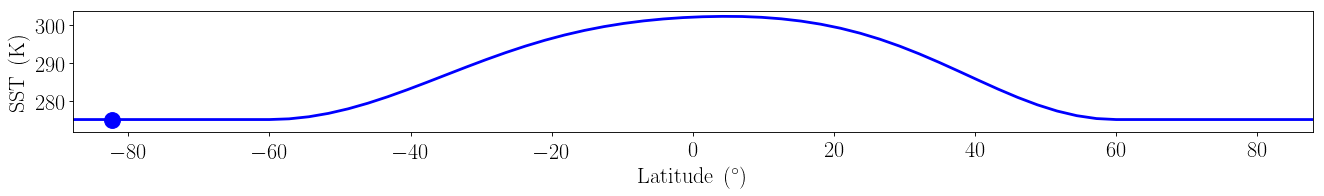

In [61]:
ilat = 2
lw = 2.5
siz = 200

plt.figure(num=None, figsize=(20, 2), dpi=80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(coor.lat,coor.TS.mean(axis=(0,2)),color='b',linewidth=lw)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.scatter(coor.lat[ilat],coor.TS.mean(axis=(0,2))[ilat],s=siz,color='b')
plt.xlim((np.min(coor.lat),np.max(coor.lat)));
plt.xlabel(r'$\mathrm{Latitude\ \left(^{\circ}\right)}$', fontsize = 20)
#ax.xaxis.labelpad = 20
plt.ylabel(r'$\mathrm{SST\ \left(K\right)}$', fontsize = 20)

In [80]:
JCON.shape

(64, 128, 60, 60)

In [87]:
JCON[ilat,:,:,:].shape

(128, 60, 60)

In [88]:
J = JCON[ilat,:,:,:].mean(axis=0)
print(J.shape)
print(J)

(60, 60)
[[ 4.77292095e-06  1.72240550e-06 -1.44912740e-05 ... -6.76831302e-07
  -1.07217891e-06 -1.66211323e-06]
 [ 1.52045963e-05  7.80347733e-06 -2.76349458e-05 ...  5.56718199e-09
   1.10675654e-07 -4.06396424e-07]
 [ 7.62947698e-07 -7.37987197e-06 -2.96197530e-05 ... -5.89208336e-07
  -8.95994007e-07 -1.51297125e-06]
 ...
 [-6.90974222e-05  1.67626852e-04 -2.44644732e-03 ...  1.98545918e-05
   7.12046756e-05  6.84149210e-05]
 [ 2.65750160e-04  5.68746008e-04 -8.39261508e-04 ... -2.54051907e-05
  -3.46307752e-05 -3.66336210e-05]
 [ 3.48785895e-04  5.02690733e-04  4.96003527e-03 ... -1.49622382e-04
  -2.59888916e-04 -3.41393763e-04]]


In [11]:
def Jacobian_figurelat(Jinp,coor,ilat=32,plot_option='CON',lw=2.5,siz=200,vmin=-3600*0.003, vmax=3600*0.003):

    if len(Jinp.shape)>=4: J = Jinp[ilat,:,:,:].mean(axis=0)
    #else: J = Jinp[ilat,:,:] tgb - 6/4/2019 - changed shape of Jacobian
    else: J = Jinp[:,:,ilat]
    # minlev = 200; # Minimum level [hPa]
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')

    fig, ax = plt.subplots(figsize=(10,10))
    # Extract the Jacobian from level minlev to the surface (index 30 here)
    # PS = 1e5; P0 = 1e5;
    # P = P0*hyai+PS*hybi; # Total pressure [Pa]
    # minind = np.argmin(abs(P-minlev*1e2));
    # IND = np.concatenate((np.arange(minind,30),np.arange(30+minind,60)),axis=0)
    J = J[IND,:]; J = J[:,IND];
    cax = ax.matshow(24*3600*J, vmin=vmin,vmax=vmax, cmap='bwr')

    x = np.linspace(0.,60.,100);
    plt.plot(x,J.shape[0]/2*x**0, color='k')
    plt.plot(J.shape[0]/2*x**0,x, color='k')

    plt.xlim((0,J.shape[0])); plt.ylim((J.shape[0],0))

    cbar = fig.colorbar(cax, pad = 0.1)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/day\right)}$', rotation=90, fontsize = 20)

    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    ax.xaxis.set_label_position('top')
    X = plt.xlabel(r'Input level', fontsize = 20)
    ax.xaxis.labelpad = 20
    Y = plt.ylabel(r'Output level', fontsize = 20)
    ax.yaxis.labelpad = 20

    # fig.canvas.draw()
    labelx = [item.get_text() for item in ax.get_xticklabels()]
    # labelx[0] = '$\mathrm{QV_{0hPa}}$'
    # labelx[1] = '$\mathrm{QV_{130hPa}}$'
    # labelx[2] = '$\mathrm{QV_{650hPa}}$'
    # labelx[3] = '$\mathrm{T_{0hPa}}$'
    # labelx[4] = '$\mathrm{T_{130hPa}}$'
    # labelx[5] = '$\mathrm{T_{650hPa}}$'
    # labelx[6] = '$\mathrm{T_{1000hPa}}$'
    labelx[0] = '$\mathrm{Q_{200hPa}}$'
    labelx[1] = '$\mathrm{Q_{500hPa}}$'
    labelx[2] = '$\mathrm{Q_{850hPa}}$'
    labelx[3] = '$\mathrm{Q_{967hPa}}$'
    labelx[4] = '$\mathrm{T_{350hPa}}$'
    labelx[5] = '$\mathrm{T_{730hPa}}$'
    labelx[6] = '$\mathrm{T_{925hPa}}$'
    labely = [item.get_text() for item in ax.get_yticklabels()]
    if plot_option=='RAD':
    #     labely[0] = '$\mathrm{LW_{0hPa}}$'
    #     labely[1] = '$\mathrm{LW_{130hPa}}$'
    #     labely[2] = '$\mathrm{LW_{650hPa}}$'
    #     labely[3] = '$\mathrm{SW_{0hPa}}$'
    #     labely[4] = '$\mathrm{SW_{130hPa}}$'
    #     labely[5] = '$\mathrm{SW_{650hPa}}$'
    #     labely[6] = '$\mathrm{SW_{1000hPa}}$'
        labely[0] = '$\mathrm{LW_{200hPa}}$'
        labely[1] = '$\mathrm{LW_{500hPa}}$'
        labely[2] = '$\mathrm{LW_{850hPa}}$'
        labely[3] = '$\mathrm{LW_{967hPa}}$'
        labely[4] = '$\mathrm{SW_{350hPa}}$'
        labely[5] = '$\mathrm{SW_{730hPa}}$'
        labely[6] = '$\mathrm{SW_{925hPa}}$'
    elif plot_option=='CON':
    #     labely[0] = '$\mathrm{\dot{QV}_{0hPa}}$'
    #     labely[1] = '$\mathrm{\dot{QV}_{130hPa}}$'
    #     labely[2] = '$\mathrm{\dot{QV}_{650hPa}}$'
    #     labely[3] = '$\mathrm{\dot{T}_{0hPa}}$'
    #     labely[4] = '$\mathrm{\dot{T}_{130hPa}}$'
    #     labely[5] = '$\mathrm{\dot{T}_{650hPa}}$'
    #     labely[6] = '$\mathrm{\dot{T}_{1000hPa}}$'
        labely[0] = '$\mathrm{\dot{Q}_{200hPa}}$'
        labely[1] = '$\mathrm{\dot{Q}_{500hPa}}$'
        labely[2] = '$\mathrm{\dot{Q}_{850hPa}}$'
        labely[3] = '$\mathrm{\dot{Q}_{967hPa}}$'
        labely[4] = '$\mathrm{\dot{T}_{350hPa}}$'
        labely[5] = '$\mathrm{\dot{T}_{730hPa}}$'
        labely[6] = '$\mathrm{\dot{T}_{925hPa}}$'

    ax.set_xticklabels(labelx)
    ax.set_yticklabels(labely)

    SSTplt = plt.axes([0.1, 0.05, 0.65, .15], facecolor='w')

    #plt.figure(num=None, figsize=(20, 2), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    SSTplt.plot(coor.lat,coor.TS.mean(axis=(0,2)),color='b',linewidth=lw)
    SSTplt.tick_params(labelsize=15)
    SSTplt.scatter(coor.lat[ilat],coor.TS.mean(axis=(0,2))[ilat],s=siz,color='b')
    SSTplt.set_xlim((np.min(coor.lat),np.max(coor.lat)));
    SSTplt.set_ylim((0.995*np.min(coor.TS.mean(axis=(0,2))),1.005*np.max(coor.TS.mean(axis=(0,2)))));
    SSTplt.set_xlabel(r'$\mathrm{Latitude\ \left(^{\circ}\right)}$', fontsize = 15)
    #ax.xaxis.labelpad = 20
    SSTplt.set_ylabel(r'$\mathrm{SST\ \left(K\right)}$', fontsize = 15)

    return fig,ax

(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14e9b81bca90>)

<Figure size 1600x1080 with 0 Axes>

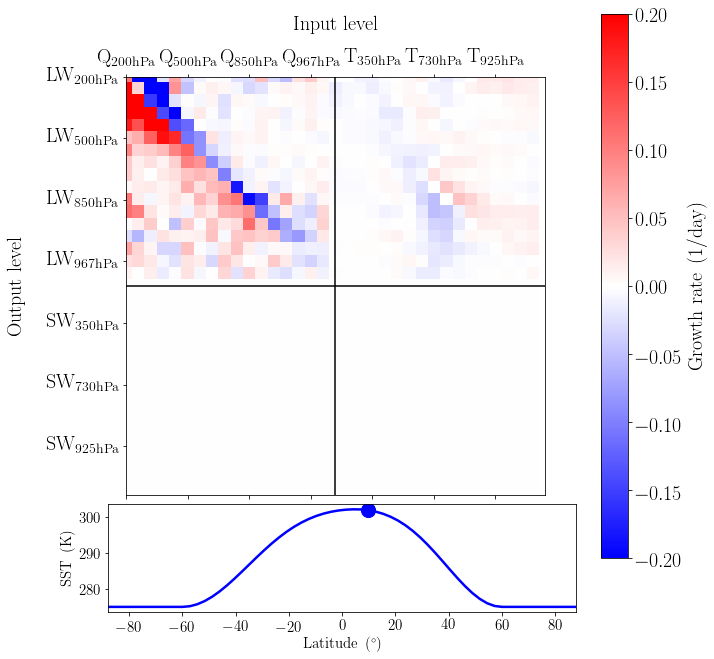

In [31]:
Jacobian_figurelat(np.mean(np.reshape(JRAD,(60,60,64,128)),axis=3),\
                   coor,ilat=35,plot_option='RAD',lw=2.5,siz=200,vmin=-0.2, vmax=0.2)

In [23]:
IND

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x147cbd51b2e8>)

<Figure size 1600x1080 with 0 Axes>

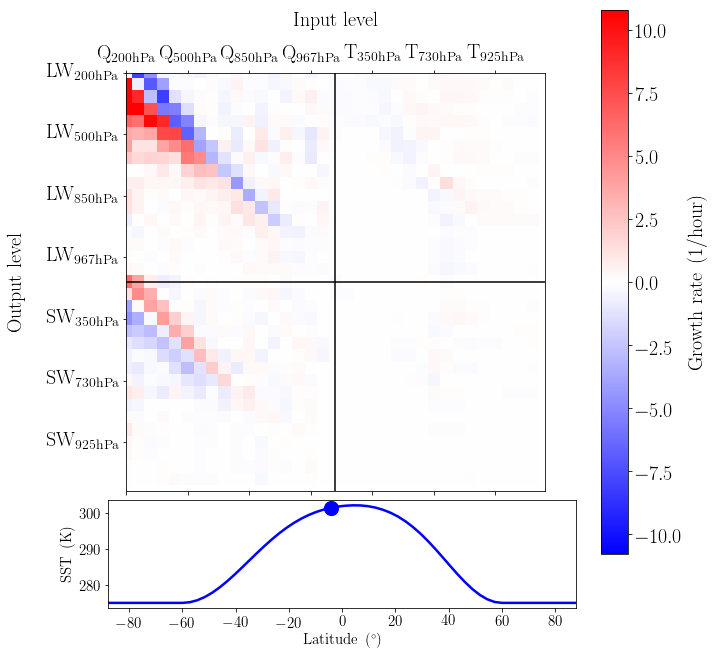

In [25]:
Jacobian_figurelat(JRAD,coor,ilat=30,plot_option='RAD',lw=2.5,siz=200,vmin=-3600*0.003, vmax=3600*0.003)

In [125]:
for ilat in range(len(coor.lat)):
    print('ilat=',ilat,'/',str(len(coor.lat)-1),end="\r")
    Jacobian_figurelat(JCON,coor,ilat=ilat,plot_option='CON',lw=2.5,siz=200,vmin=-3600*0.003, vmax=3600*0.003)
    plt.savefig('PNG_DATA/'+'CON'+str(ilat))
    plt.close('all')

tgb - 6/4/2019 - NE runs

In [12]:
X, truth = md.valid_gen[itime]

In [19]:
np.floor(8192/32)

256.0

In [21]:
ind = 0
X[256*ind:256*(ind+1),:]

<xarray.DataArray 'vars' (sample: 256, var_names: 304)>
array([[ 0.000252,  0.000241,  0.000174, ...,  0.117959, -0.003178, -0.059579],
       [ 0.000252,  0.000242,  0.000174, ...,  0.118111, -0.002224, -0.058024],
       [ 0.000252,  0.000242,  0.000173, ...,  0.118346, -0.001583, -0.056919],
       ...,
       [ 0.000254,  0.000244,  0.000169, ...,  0.072381, -0.009403, -0.055445],
       [ 0.000255,  0.000244,  0.000169, ...,  0.072158, -0.009078, -0.053791],
       [ 0.000255,  0.000245,  0.000169, ...,  0.072126, -0.010757, -0.05609 ]],
      dtype=float32)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' ... 'SOLIN' 'SHFLX' 'LHFLX'
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
Dimensions without coordinates: sample

In [15]:
Nt = 10
JCON = np.zeros((60,60,8192))
JRAD = np.zeros((60,60,8192))

for it in range(Nt):
    print('itime=',it,'/',Nt,end="\r")
    JCONa,JRADa = get_RADCONjacobian(NN,md,it)
    JCON = JCONa/(it+1)+it/(it+1)*JCON
    JRAD = JRADa/(it+1)+it/(it+1)*JRAD

/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


(8192, 218, 304)
(8192, 218, 304)


KeyboardInterrupt: 

In [17]:
for ilat in range(len(coor.lat)):
    print('ilat=',ilat,'/',str(len(coor.lat)-1),end="\r")
    Jacobian_figurelat(np.mean(np.reshape(JCON,(60,60,64,128)),axis=3),\
                   coor,ilat=ilat,plot_option='CON',lw=2.5,siz=200,vmin=-0.2, vmax=0.2)
    plt.savefig('PNG_DATA/'+'CON'+str(ilat))
    Jacobian_figurelat(np.mean(np.reshape(JRAD,(60,60,64,128)),axis=3),\
                   coor,ilat=ilat,plot_option='RAD',lw=2.5,siz=200,vmin=-0.2, vmax=0.2)
    plt.savefig('PNG_DATA/'+'RAD'+str(ilat))
    plt.close('all')

In [10]:
def Jacobian_figure(J,plot_option):
# minlev = 200; # Minimum level [hPa]
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')

    fig, ax = plt.subplots(figsize=(10,10))
    # Extract the Jacobian from level minlev to the surface (index 30 here)
    # PS = 1e5; P0 = 1e5;
    # P = P0*hyai+PS*hybi; # Total pressure [Pa]
    # minind = np.argmin(abs(P-minlev*1e2));
    # IND = np.concatenate((np.arange(minind,30),np.arange(30+minind,60)),axis=0)
    J = J[IND,:]; J = J[:,IND];
    cax = ax.matshow(3600*J, vmin=-3600*0.003, vmax=3600*0.003, cmap='bwr')

    x = np.linspace(0.,60.,100);
    plt.plot(x,J.shape[0]/2*x**0, color='k')
    plt.plot(J.shape[0]/2*x**0,x, color='k')

    plt.xlim((0,J.shape[0])); plt.ylim((J.shape[0],0))

    cbar = fig.colorbar(cax, pad = 0.1)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/hour\right)}$', rotation=90, fontsize = 20)

    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    ax.xaxis.set_label_position('top')
    X = plt.xlabel(r'Input level', fontsize = 20)
    ax.xaxis.labelpad = 20
    Y = plt.ylabel(r'Output level', fontsize = 20)
    ax.yaxis.labelpad = 20

    # fig.canvas.draw()
    labelx = [item.get_text() for item in ax.get_xticklabels()]
    # labelx[0] = '$\mathrm{QV_{0hPa}}$'
    # labelx[1] = '$\mathrm{QV_{130hPa}}$'
    # labelx[2] = '$\mathrm{QV_{650hPa}}$'
    # labelx[3] = '$\mathrm{T_{0hPa}}$'
    # labelx[4] = '$\mathrm{T_{130hPa}}$'
    # labelx[5] = '$\mathrm{T_{650hPa}}$'
    # labelx[6] = '$\mathrm{T_{1000hPa}}$'
    labelx[0] = '$\mathrm{Q_{200hPa}}$'
    labelx[1] = '$\mathrm{Q_{500hPa}}$'
    labelx[2] = '$\mathrm{Q_{850hPa}}$'
    labelx[3] = '$\mathrm{Q_{967hPa}}$'
    labelx[4] = '$\mathrm{T_{350hPa}}$'
    labelx[5] = '$\mathrm{T_{730hPa}}$'
    labelx[6] = '$\mathrm{T_{925hPa}}$'
    labely = [item.get_text() for item in ax.get_yticklabels()]
    if plot_option=='RAD':
    #     labely[0] = '$\mathrm{LW_{0hPa}}$'
    #     labely[1] = '$\mathrm{LW_{130hPa}}$'
    #     labely[2] = '$\mathrm{LW_{650hPa}}$'
    #     labely[3] = '$\mathrm{SW_{0hPa}}$'
    #     labely[4] = '$\mathrm{SW_{130hPa}}$'
    #     labely[5] = '$\mathrm{SW_{650hPa}}$'
    #     labely[6] = '$\mathrm{SW_{1000hPa}}$'
        labely[0] = '$\mathrm{LW_{200hPa}}$'
        labely[1] = '$\mathrm{LW_{500hPa}}$'
        labely[2] = '$\mathrm{LW_{850hPa}}$'
        labely[3] = '$\mathrm{LW_{967hPa}}$'
        labely[4] = '$\mathrm{SW_{350hPa}}$'
        labely[5] = '$\mathrm{SW_{730hPa}}$'
        labely[6] = '$\mathrm{SW_{925hPa}}$'
    elif plot_option=='CON':
    #     labely[0] = '$\mathrm{\dot{QV}_{0hPa}}$'
    #     labely[1] = '$\mathrm{\dot{QV}_{130hPa}}$'
    #     labely[2] = '$\mathrm{\dot{QV}_{650hPa}}$'
    #     labely[3] = '$\mathrm{\dot{T}_{0hPa}}$'
    #     labely[4] = '$\mathrm{\dot{T}_{130hPa}}$'
    #     labely[5] = '$\mathrm{\dot{T}_{650hPa}}$'
    #     labely[6] = '$\mathrm{\dot{T}_{1000hPa}}$'
        labely[0] = '$\mathrm{\dot{Q}_{200hPa}}$'
        labely[1] = '$\mathrm{\dot{Q}_{500hPa}}$'
        labely[2] = '$\mathrm{\dot{Q}_{850hPa}}$'
        labely[3] = '$\mathrm{\dot{Q}_{967hPa}}$'
        labely[4] = '$\mathrm{\dot{T}_{350hPa}}$'
        labely[5] = '$\mathrm{\dot{T}_{730hPa}}$'
        labely[6] = '$\mathrm{\dot{T}_{925hPa}}$'

    ax.set_xticklabels(labelx)
    ax.set_yticklabels(labely)
    
    return fig,ax